In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

#1. Вспомогательные функции

In [12]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

def compute_loss(Y_one_hot, Y_pred):
    epsilon = 1e-9
    m = Y_one_hot.shape[0]
    loss = -np.sum(Y_one_hot * np.log(Y_pred + epsilon)) / m
    return loss

def get_accuracy(Y_true, Y_pred_classes):
    return np.mean(Y_true == Y_pred_classes)

#2. Загрузка и предобработка данных

In [13]:
try:
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
    print("Данные загружены")
except Exception as e:
    print(f"Ошибка: {e}")
    exit()


X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

X /= 255.0

X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.reshape(-1, 1))

print(f"Размер обучающей выборки (X): {X_train.shape}")
print(f"Размер обучающей выборки (y): {y_train_one_hot.shape}")
print(f"Размер тестовой выборки (X): {X_test.shape}")
print(f"Размер тестовой выборки (y): {y_test_one_hot.shape}")

Данные загружены
Размер обучающей выборки (X): (60000, 784)
Размер обучающей выборки (y): (60000, 10)
Размер тестовой выборки (X): (10000, 784)
Размер тестовой выборки (y): (10000, 10)


#3. Примеры изображений

Пять случайных изображений из обучающей выборки


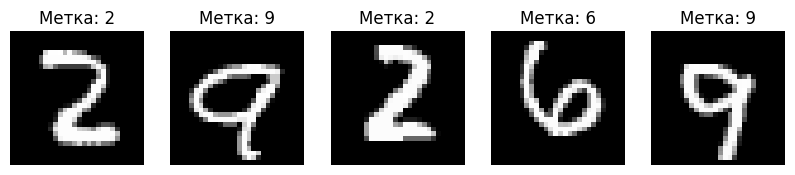

In [14]:
print("Пять случайных изображений из обучающей выборки")
plt.figure(figsize=(10, 4))
for i in range(5):
    idx = np.random.randint(0, X_train.shape[0])
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Метка: {y_train[idx]}")
    plt.axis('off')
plt.show()

#4. Реализация нейронной сети

In [15]:
class TwoLayerNet_NumPy:
    def __init__(self, input_size, hidden_size, output_size):
        self.params = {}

        # He для ReLU (скрытый слой)
        self.params['W1'] = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.params['b1'] = np.zeros(hidden_size)

        # Xavier/Glorot для Softmax (выходной слой)
        self.params['W2'] = np.random.randn(hidden_size, output_size) * np.sqrt(1.0 / hidden_size)
        self.params['b2'] = np.zeros(output_size)

        self.cache = {} # Для хранения промежуточных значений

    def forward(self, X):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        # Скрытый слой
        Z1 = X @ W1 + b1
        A1 = relu(Z1)

        # Выходной слой
        Z2 = A1 @ W2 + b2
        A2 = softmax(Z2)

        self.cache = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
        return A2

    def backward(self, X, Y_one_hot):
        m = X.shape[0]
        W1, W2 = self.params['W1'], self.params['W2']
        A1, A2 = self.cache['A1'], self.cache['A2']
        Z1 = self.cache['Z1']

        grads = {}

        # 1. Градиент для выходного слоя (Softmax + Cross-Entropy)
        # dL/dZ2 = A2 - Y_one_hot
        dZ2 = A2 - Y_one_hot

        # dL/dW2 = (A1.T @ dZ2) / m
        grads['W2'] = (A1.T @ dZ2) / m
        # dL/db2 = sum(dZ2) / m
        grads['b2'] = np.sum(dZ2, axis=0) / m

        # 2. Градиент для скрытого слоя
        # dL/dA1 = dZ2 @ W2.T
        dA1 = dZ2 @ W2.T
        # dL/dZ1 = dL/dA1 * g'(Z1) (где g' - производная ReLU)
        dZ1 = dA1 * relu_derivative(Z1)

        # dL/dW1 = (X.T @ dZ1) / m
        grads['W1'] = (X.T @ dZ1) / m
        # dL/db1 = sum(dZ1) / m
        grads['b1'] = np.sum(dZ1, axis=0) / m

        return grads

    def update_params(self, grads, learning_rate):
        self.params['W1'] -= learning_rate * grads['W1']
        self.params['b1'] -= learning_rate * grads['b1']
        self.params['W2'] -= learning_rate * grads['W2']
        self.params['b2'] -= learning_rate * grads['b2']

    def predict(self, X):
        Y_pred_probs = self.forward(X)
        return np.argmax(Y_pred_probs, axis=1)

#5. Обучение модели

In [16]:
INPUT_SIZE = 28 * 28  # 784
HIDDEN_SIZE = 300
OUTPUT_SIZE = 10
LEARNING_RATE = 0.1
EPOCHS = 20
BATCH_SIZE = 64


net = TwoLayerNet_NumPy(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
num_batches = X_train.shape[0] // BATCH_SIZE

print(f"Параметры: Epochs={EPOCHS}, Batch Size={BATCH_SIZE}, LR={LEARNING_RATE}, Hidden Neurons={HIDDEN_SIZE}")

for epoch in range(EPOCHS):
    start_time = time.time()

    permutation = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[permutation]
    y_train_one_hot_shuffled = y_train_one_hot[permutation]

    epoch_loss = 0

    for i in range(num_batches):
        start_idx = i * BATCH_SIZE
        end_idx = start_idx + BATCH_SIZE
        X_batch = X_train_shuffled[start_idx:end_idx]
        y_batch = y_train_one_hot_shuffled[start_idx:end_idx]

        # 1. Прямое распространение
        y_pred = net.forward(X_batch)

        # 2. Вычисление потерь
        loss = compute_loss(y_batch, y_pred)
        epoch_loss += loss

        # 3. Обратное распространение
        grads = net.backward(X_batch, y_batch)

        # 4. Обновление весов
        net.update_params(grads, LEARNING_RATE)

    end_time = time.time()
    epoch_duration = end_time - start_time

    # Расчет ошибки и точности
    train_preds_probs = net.forward(X_train)
    train_loss = compute_loss(y_train_one_hot, train_preds_probs)
    train_preds_classes = np.argmax(train_preds_probs, axis=1)
    train_accuracy = get_accuracy(y_train, train_preds_classes)

    print(f"Эпоха [{epoch+1}/{EPOCHS}] | "
          f"Время: {epoch_duration:.2f} с | "
          f"Ошибка (Train): {train_loss:.4f} | "
          f"Точность (Train): {train_accuracy * 100:.2f}%")

Параметры: Epochs=20, Batch Size=64, LR=0.1, Hidden Neurons=300
Эпоха [1/20] | Время: 7.58 с | Ошибка (Train): 0.2262 | Точность (Train): 93.55%
Эпоха [2/20] | Время: 4.63 с | Ошибка (Train): 0.1577 | Точность (Train): 95.54%
Эпоха [3/20] | Время: 6.77 с | Ошибка (Train): 0.1199 | Точность (Train): 96.71%
Эпоха [4/20] | Время: 4.65 с | Ошибка (Train): 0.0981 | Точность (Train): 97.31%
Эпоха [5/20] | Время: 6.90 с | Ошибка (Train): 0.0835 | Точность (Train): 97.67%
Эпоха [6/20] | Время: 4.56 с | Ошибка (Train): 0.0722 | Точность (Train): 97.99%
Эпоха [7/20] | Время: 6.76 с | Ошибка (Train): 0.0624 | Точность (Train): 98.31%
Эпоха [8/20] | Время: 4.66 с | Ошибка (Train): 0.0538 | Точность (Train): 98.58%
Эпоха [9/20] | Время: 6.33 с | Ошибка (Train): 0.0473 | Точность (Train): 98.80%
Эпоха [10/20] | Время: 4.57 с | Ошибка (Train): 0.0419 | Точность (Train): 99.00%
Эпоха [11/20] | Время: 5.74 с | Ошибка (Train): 0.0402 | Точность (Train): 99.00%
Эпоха [12/20] | Время: 4.62 с | Ошибка (Tra

#6. Оценка на тестовом наборе

In [17]:
print("Оценка качества на тестовом наборе данных")
test_preds_probs = net.forward(X_test)
test_loss = compute_loss(y_test_one_hot, test_preds_probs)
test_preds_classes = np.argmax(test_preds_probs, axis=1)
test_accuracy = get_accuracy(y_test, test_preds_classes)

print(f"Ошибка классификации (Test): {test_loss:.4f}")
print(f"Точность классификации (Test): {test_accuracy * 100:.2f}%")

Оценка качества на тестовом наборе данных

Результаты
Ошибка классификации (Test): 0.0619
Точность классификации (Test): 98.10%
